### 라이브러리
---

In [18]:
import os
import tensorflow
import numpy as np
import transformers
import datasets
import torch
import gc
import matplotlib.pyplot as plt
from datasets import load_metric, load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments

# STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성
---

### NSMC(Naver sentiment movie corpus)

Each instance is a movie review written by Korean internet users on Naver, the most commonly used search engine in Korea. Each row can be broken down into the following fields:

- id: A unique review ID, provided by Naver
- document: The actual movie review
- label: Binary labels for sentiment analysis, where 0 denotes negative, and 1, positive
- train: 150000 rows / test: 50000 rows

### Huggingface dataset 구성
train - 4000
validation - 800
test - 1500

In [2]:
train = load_dataset('nsmc', split='train[:4000]')
validation = load_dataset('nsmc', split='train[-800:]')
test = load_dataset('nsmc', split='test[:1500]')

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)
Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


In [3]:
cols = train.column_names
cols

['id', 'document', 'label']

In [4]:
print(f"Train Data 개수: {len(train)}, Validation Data 개수: {len(validation)}, Test Data 개수: {len(test)}")

Train Data 개수: 4000, Validation Data 개수: 800, Test Data 개수: 1500


### 문장 길이가 maxlen 이하인 데이터 필터링

In [5]:
def filter_dataset_by_length(dataset, max_length=50):
    filtered_dataset = dataset.filter(lambda example: len(example['document']) <= max_length)
    return filtered_dataset

In [6]:
train = filter_dataset_by_length(train)
validation = filter_dataset_by_length(validation)
test = filter_dataset_by_length(test)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [7]:
total_data_text = list(train['document']) + list(validation['document']) + list(test['document'])
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 최대 : ', np.max(num_tokens))

문장길이 최대 :  50


In [8]:
print(f"Train Data 개수: {len(train)}, Validation Data 개수: {len(validation)}, Test Data 개수: {len(test)}")

Train Data 개수: 3255, Validation Data 개수: 671, Test Data 개수: 1242


# STEP 2. klue/bert-base model 및 tokenizer 불러오기
---

In [9]:
huggingface_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
huggingface_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base", num_labels = 2)

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

# STEP 3. 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기
---

In [10]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [11]:
hf_train_dataset = train.map(transform, batched=True)
hf_val_dataset = validation.map(transform, batched=True)
hf_test_dataset = test.map(transform, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [12]:
output_dir = os.getenv('HOME')+'/aiffel/NLP/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                        #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [13]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [14]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 3255
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1221


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.391954,0.845007
2,0.403300,0.654888,0.833085
3,0.215400,0.748196,0.836066


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/NLP/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/NLP/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/NLP/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/NLP/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/NLP/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/NLP/transformers/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don'

TrainOutput(global_step=1221, training_loss=0.2811355153426687, metrics={'train_runtime': 1063.1561, 'train_samples_per_second': 9.185, 'train_steps_per_second': 1.148, 'total_flos': 2569279455590400.0, 'train_loss': 0.2811355153426687, 'epoch': 3.0})

In [15]:
inital_result = trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1242
  Batch size = 8


In [16]:
results_dict = {}
results_dict['Initial_model'] = inital_result['eval_accuracy']

# STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
---

In [19]:
# 실행 전 메모리 사용량 측정
initial_memory_allocated = torch.cuda.memory_allocated()
initial_max_memory_allocated = torch.cuda.max_memory_allocated()

# 가비지 컬렉션 수행
gc.collect()

# CUDA 캐시된 메모리 비우기
torch.cuda.empty_cache()

# 모델과 토크나이저 버퍼 비우기
del huggingface_model, huggingface_tokenizer

# 실행 후 메모리 사용량 측정
final_memory_allocated = torch.cuda.memory_allocated()
final_max_memory_allocated = torch.cuda.max_memory_allocated()

# 메모리 사용량 출력
print("실행 전 할당된 메모리:", initial_memory_allocated)
print("실행 후 할당된 메모리:", final_memory_allocated)
print("최대 할당된 메모리 (실행 전):", initial_max_memory_allocated)
print("최대 할당된 메모리 (실행 후):", final_max_memory_allocated)

실행 전 할당된 메모리: 1833351168
실행 후 할당된 메모리: 1833351168
최대 할당된 메모리 (실행 전): 8338522624
최대 할당된 메모리 (실행 후): 8338522624


In [20]:
torch.cuda.memory_reserved()

1908408320

In [21]:
huggingface_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
huggingface_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base", num_labels = 2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

In [22]:
# def transform(data):
#     return huggingface_tokenizer(
#         data['document'],
#         truncation = True,
#         padding = 'max_length',
#         return_token_type_ids = False,
#         )

In [23]:
# hf_train_dataset = train.map(transform, batched=True)
# hf_val_dataset = validation.map(transform, batched=True)
# hf_test_dataset = test.map(transform, batched=True)

In [24]:
output_dir = os.getenv('HOME')+'/aiffel/NLP/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                        #learning_rate
    per_device_train_batch_size = 10,   # 각 device 당 batch size
    per_device_eval_batch_size = 10,    # evaluation 시에 batch size
    num_train_epochs = 7,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [25]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [26]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 3255
  Num Epochs = 7
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 2282


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.375724,0.834575
2,0.355600,0.550137,0.827124
3,0.355600,0.843699,0.833085
4,0.176200,0.792582,0.843517
5,0.066400,0.979478,0.836066
6,0.066400,1.023596,0.837556
7,0.027800,1.020963,0.845007


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 10
Saving model checkpoint to /aiffel/aiffel/NLP/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/NLP/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/NLP/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 10
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 10
Saving model checkpoint to /aiffel/aiffel/NLP/transformers/chec

TrainOutput(global_step=2282, training_loss=0.14009410994393484, metrics={'train_runtime': 2373.7788, 'train_samples_per_second': 9.599, 'train_steps_per_second': 0.961, 'total_flos': 5994985396377600.0, 'train_loss': 0.14009410994393484, 'epoch': 7.0})

In [27]:
finetuned_result = trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1242
  Batch size = 10


In [28]:
results_dict['FineTuned_model'] = finetuned_result['eval_accuracy']

# STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
---

In [63]:
# 실행 전 메모리 사용량 측정
initial_memory_allocated = torch.cuda.memory_allocated()
initial_max_memory_allocated = torch.cuda.max_memory_allocated()

# 가비지 컬렉션 수행
gc.collect()

# CUDA 캐시된 메모리 비우기
torch.cuda.empty_cache()

# 모델과 토크나이저 버퍼 비우기
del huggingface_model, huggingface_tokenizer

# 실행 후 메모리 사용량 측정
final_memory_allocated = torch.cuda.memory_allocated()
final_max_memory_allocated = torch.cuda.max_memory_allocated()

# 메모리 사용량 출력
print("실행 전 할당된 메모리:", initial_memory_allocated)
print("실행 후 할당된 메모리:", final_memory_allocated)
print("최대 할당된 메모리 (실행 전):", initial_max_memory_allocated)
print("최대 할당된 메모리 (실행 후):", final_max_memory_allocated)

실행 전 할당된 메모리: 3572069376
실행 후 할당된 메모리: 1788524544
최대 할당된 메모리 (실행 전): 11740495360
최대 할당된 메모리 (실행 후): 11740495360


In [64]:
huggingface_model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")
huggingface_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base", num_labels = 2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file https://huggingface.co/klue/bert-base/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transform

In [65]:
# def transform(data):
#     return huggingface_tokenizer(
#         data['document'],
#         truncation = True,
#         padding = 'max_length',
#         return_token_type_ids = False,
#         )

In [66]:
# hf_train_dataset = train.map(transform, batched=True)
# hf_val_dataset = validation.map(transform, batched=True)
# hf_test_dataset = test.map(transform, batched=True)

In [69]:
output_dir = os.getenv('HOME')+'/aiffel/NLP/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 3e-5,                        #learning_rate
    per_device_train_batch_size = 12,   # 각 device 당 batch size
    per_device_eval_batch_size = 12,    # evaluation 시에 batch size
    num_train_epochs = 7,                     # train 시킬 총 epochs
    weight_decay = 0.02,                        # weight decay
    group_by_length = True                       # bucketing
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [70]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [71]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 3255
  Num Epochs = 7
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 12
  Gradient Accumulation steps = 1
  Total optimization steps = 1904


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.381005,0.842027
2,0.330000,0.656339,0.812221
3,0.330000,0.811882,0.846498
4,0.102300,0.907390,0.845007
5,0.102300,1.146797,0.839046
6,0.032900,1.126576,0.837556
7,0.032900,1.147162,0.842027


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 12
Saving model checkpoint to /aiffel/aiffel/NLP/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/NLP/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/NLP/transformers/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 12
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 671
  Batch size = 12
Saving model checkpoint to /aiffel/aiffel/NLP/transformers/chec

TrainOutput(global_step=1904, training_loss=0.12568470209586521, metrics={'train_runtime': 2453.5085, 'train_samples_per_second': 9.287, 'train_steps_per_second': 0.776, 'total_flos': 5994985396377600.0, 'train_loss': 0.12568470209586521, 'epoch': 7.0})

In [72]:
bucketing_result = trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1242
  Batch size = 12


In [73]:
results_dict['Bucketing_model'] = bucketing_result['eval_accuracy']

In [74]:
results_dict

{'Initial_model': 0.8502415458937198,
 'FineTuned_model': 0.8582930756843801,
 'Bucketing_model': 0.8590982286634461}

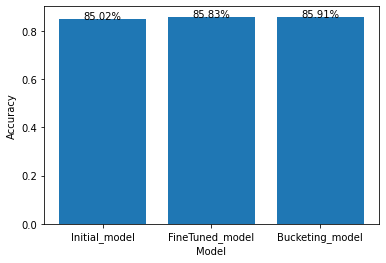

In [75]:
import matplotlib.pyplot as plt

# Extracting keys and values from the dictionary
keys = list(results_dict.keys())
values = list(results_dict.values())

# Creating the bar graph
plt.bar(keys, values)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
for i, v in enumerate(values):
    plt.text(i, v, str(round(v*100,2))+'%', ha='center')


# Displaying the plot
plt.show()

## 결과 및 회고
1. 데이터 불러오기 - 총 15만 개의 train 데이터 중 4천 개를 train 데이터로, 8백 개를 validation 데이터로 설정했다.     
    총 5만 개의 test 데이터 중 1천5백 개를 test 데이터로 설정해서 불러왔따.
2. 데이터 필터링 - 최대 문장 길이가 50인 문장만 필터링해서 Train Data 개수: 3255, Validation Data 개수: 671, Test Data 개수: 1242로 줄였다.
3. Finetuning - batch size를 10으로 늘리고 epoch도 7로 늘렸다
4. Bucketing - Finetuning과 같은 조건에서 group_by_length를 True로 설정했다.

설정을 변경하니 Test Accuracy가 증가한 걸 보니 설정을 잘한 거 같다.   
이번 프로젝트에서 가장 어려웠던 점은 첫번째가 메모리 할당 문제로 학습이 안 되는 것이었다.   
이 문제는 한 모델의 학습과 테스트가 끝난 후 메모리 정리를 한 다음에 했더니 해결이 되었다.   
모델을 사용할 때 batch size나 메모리를 잘 확인하면서 해야된다는 것을 배웠다.